In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from datetime import datetime
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats import norm

In [17]:
tickers = ["ACP", "DNP", "OPL", "ATT", "KGH", "PGE", "SPL", "PKO"]
files = [f"/content/drive/MyDrive/Analizy_Inwestycyjne/{t.lower()}_w.csv" for t in tickers]

data = {}
for t, f in zip(tickers, files):
    df = pd.read_csv(f)
    df['Data'] = pd.to_datetime(df['Data'])
    df = df.set_index('Data')
    data[t] = df['Zamkniecie']

In [18]:
prices = pd.concat(data, axis=1)
prices = prices.dropna()

In [19]:
returns = np.log(prices / prices.shift(1)).dropna()

In [20]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

print("Średnie tygodniowe stopy zwrotu:")
print(mean_returns.round(4))
print("\nKowariancja:")
print(cov_matrix.round(6))

Średnie tygodniowe stopy zwrotu:
ACP    0.0049
DNP    0.0016
OPL    0.0022
ATT   -0.0009
KGH    0.0014
PGE    0.0029
SPL    0.0057
PKO    0.0057
dtype: float64

Kowariancja:
          ACP       DNP       OPL       ATT       KGH       PGE       SPL  \
ACP  0.001439  0.000356  0.000394  0.000162  0.000224  0.000358  0.000396   
DNP  0.000356  0.001985  0.000347  0.000078  0.000450  0.000286  0.000585   
OPL  0.000394  0.000347  0.000978  0.000121  0.000342  0.000363  0.000366   
ATT  0.000162  0.000078  0.000121  0.002668  0.001002  0.000862  0.000369   
KGH  0.000224  0.000450  0.000342  0.001002  0.003119  0.000923  0.000797   
PGE  0.000358  0.000286  0.000363  0.000862  0.000923  0.003295  0.000689   
SPL  0.000396  0.000585  0.000366  0.000369  0.000797  0.000689  0.002035   
PKO  0.000434  0.000547  0.000357  0.000675  0.000895  0.000648  0.001711   

          PKO  
ACP  0.000434  
DNP  0.000547  
OPL  0.000357  
ATT  0.000675  
KGH  0.000895  
PGE  0.000648  
SPL  0.001711  
PKO 

In [21]:
train = returns.iloc[:-52]
test = returns.iloc[-52:]

mean_train = train.mean()
cov_train = train.cov()

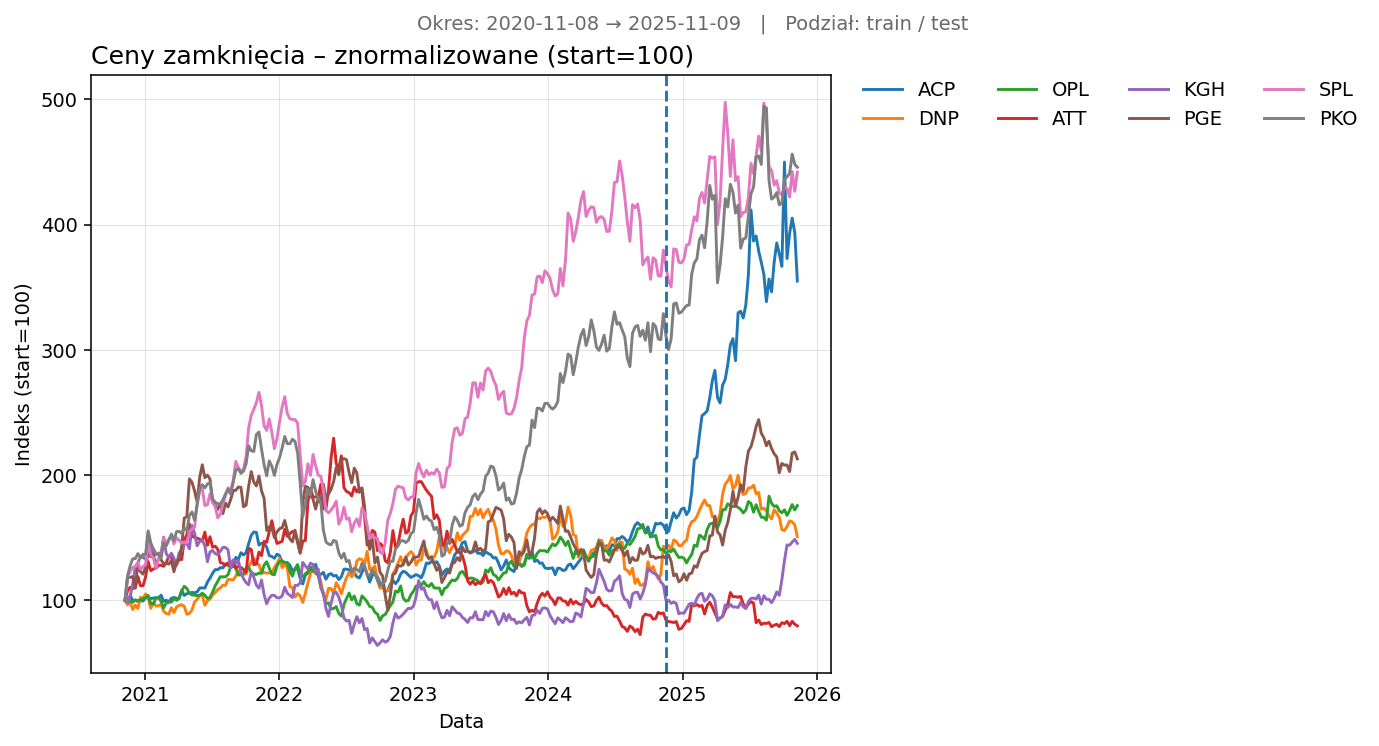

In [22]:
split_date = test.index[0]

px_norm = prices / prices.iloc[0] * 100.0

plt.figure(figsize=(10,5.5), dpi=140)
for col in px_norm.columns:
    plt.plot(px_norm.index, px_norm[col], label=col)

plt.axvline(split_date, linestyle='--', linewidth=1.5)

plt.title("Ceny zamknięcia – znormalizowane (start=100)", loc='left', fontsize=13)
plt.suptitle("Okres: {} → {}   |   Podział: train / test".format(px_norm.index[0].date(), px_norm.index[-1].date()),
             y=0.96, fontsize=10, color='dimgray')
plt.xlabel("Data"); plt.ylabel("Indeks (start=100)")
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.legend(ncol=4, bbox_to_anchor=(1.02, 1.02), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

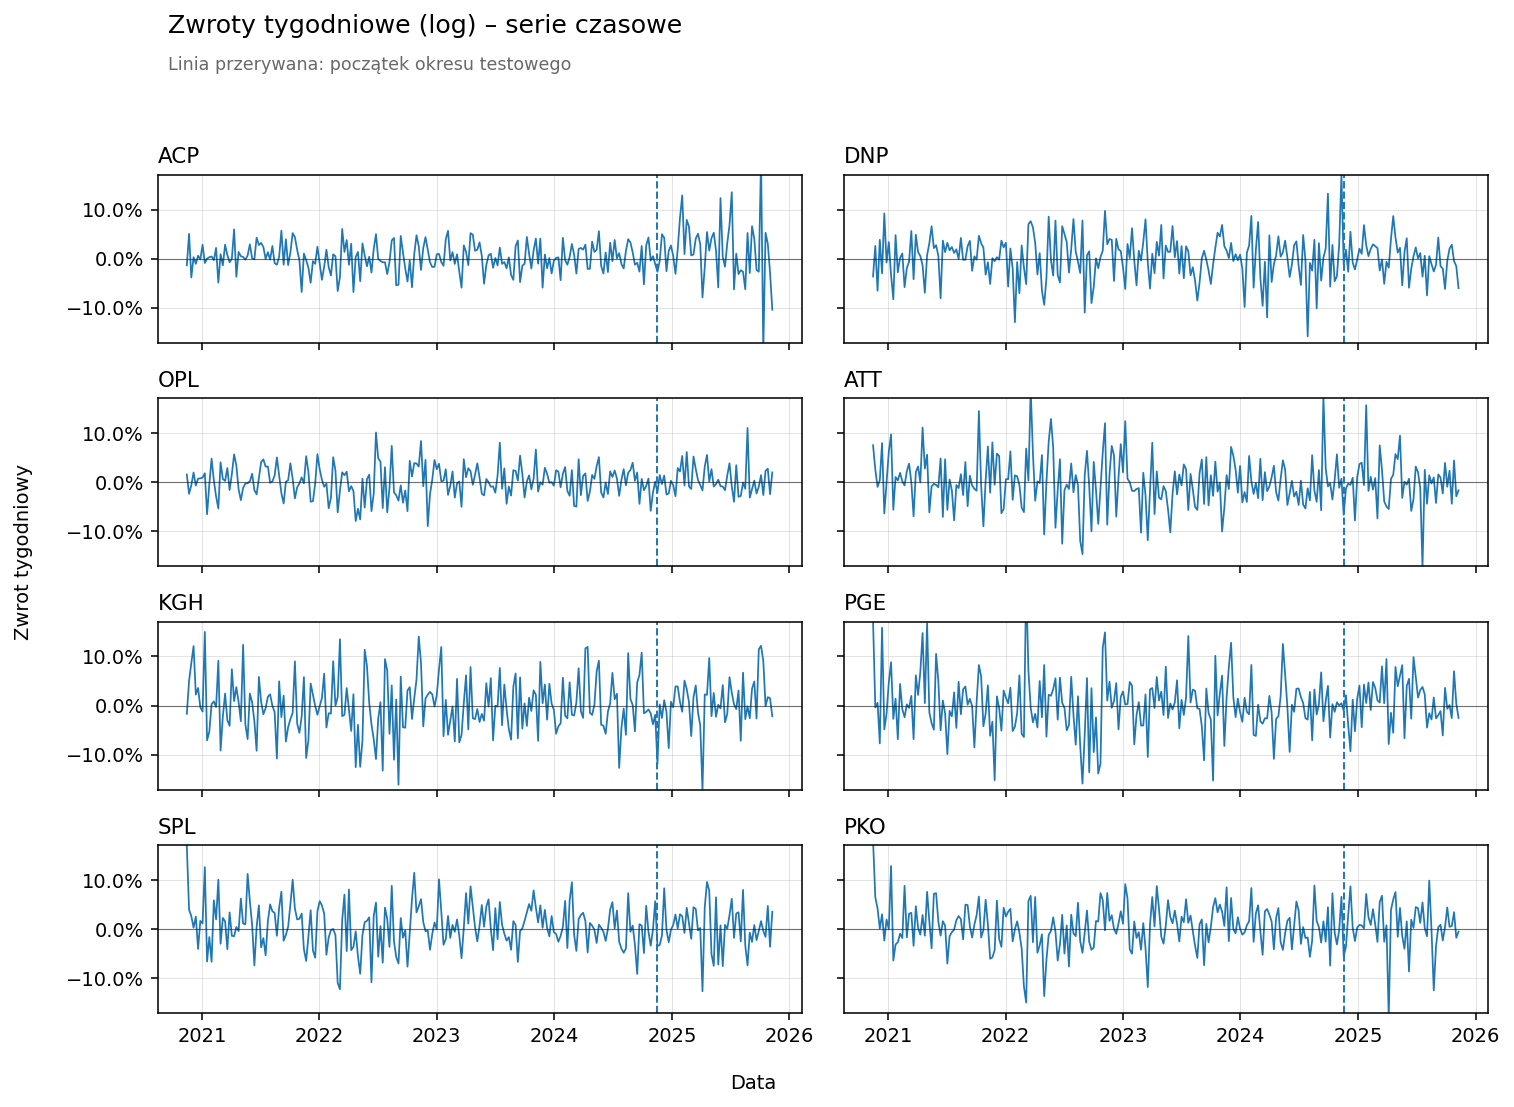

In [26]:
rets_pct = returns * 100

lim = np.nanpercentile(np.abs(rets_pct.values), 99.5)
ylim = (-lim, lim)

tickers = rets_pct.columns.tolist()
rows, cols = 4, 2
fig, axes = plt.subplots(rows, cols, figsize=(11,8), dpi=140, sharex=True, sharey=True)

for i, t in enumerate(tickers):
    r = i // cols; c = i % cols
    ax = axes[r, c]
    ax.plot(rets_pct.index, rets_pct[t], linewidth=0.9)
    ax.axhline(0, color='k', linewidth=0.6, alpha=0.5)
    ax.axvline(split_date, linestyle='--', linewidth=1.0)
    ax.set_title(t, loc='left', fontsize=11)
    ax.set_ylim(ylim)
    ax.grid(True, linewidth=0.3, alpha=0.6)
    ax.yaxis.set_major_formatter(PercentFormatter(100))

fig.suptitle("Zwroty tygodniowe (log) – serie czasowe", fontsize=13, x=0.12, ha='left')
fig.text(0.12, 0.93, "Linia przerywana: początek okresu testowego", fontsize=9, color='dimgray')
fig.text(0.5, 0.02, "Data", ha='center')
fig.text(0.02, 0.5, "Zwrot tygodniowy", va='center', rotation='vertical')
plt.tight_layout(rect=(0.04, 0.04, 1, 0.92))
plt.show()


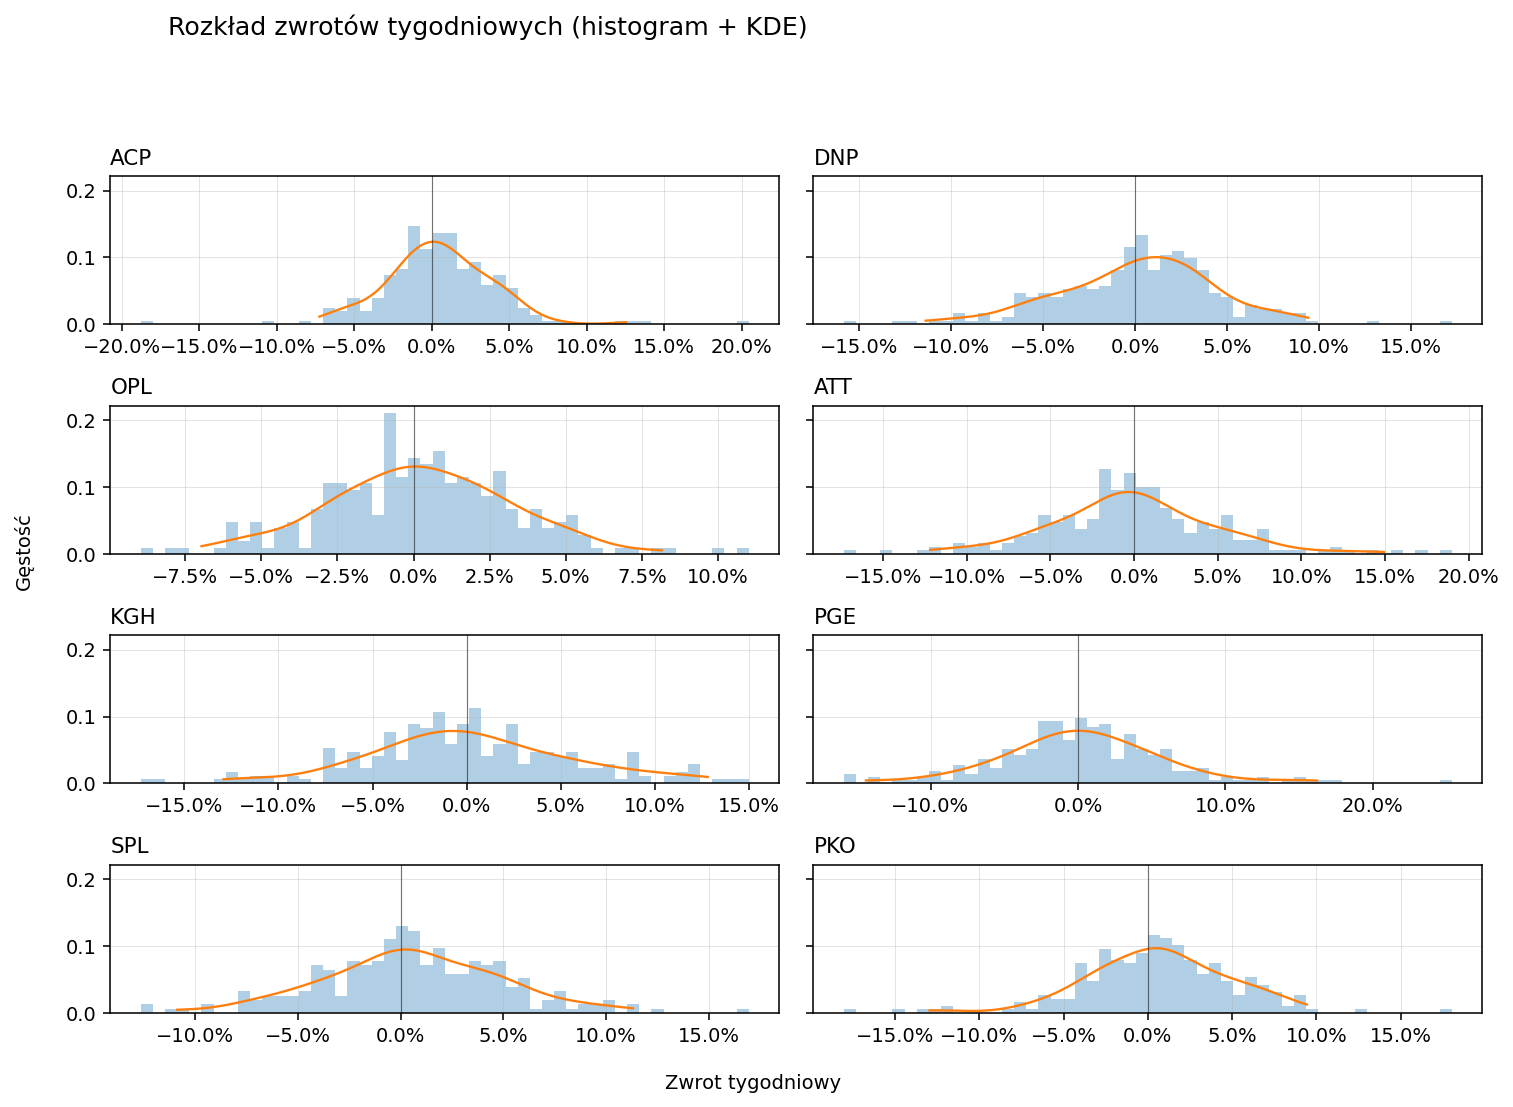

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(11,8), dpi=140, sharex=False, sharey=True)
bins = 50

for i, t in enumerate(tickers):
    r = i // 2; c = i % 2
    ax = axes[r, c]
    series = rets_pct[t].dropna()
    ax.hist(series, bins=bins, density=True, alpha=0.35)
    kde = st.gaussian_kde(series)
    xs = np.linspace(series.quantile(0.01), series.quantile(0.99), 400)
    ax.plot(xs, kde(xs), linewidth=1.2)
    ax.axvline(0, color='k', linewidth=0.6, alpha=0.5)
    ax.set_title(t, loc='left', fontsize=11)
    ax.grid(True, linewidth=0.3, alpha=0.6)
    ax.xaxis.set_major_formatter(PercentFormatter(100))

fig.suptitle("Rozkład zwrotów tygodniowych (histogram + KDE)", fontsize=13, x=0.12, ha='left')
fig.text(0.5, 0.02, "Zwrot tygodniowy", ha='center')
fig.text(0.02, 0.5, "Gęstość", va='center', rotation='vertical')
plt.tight_layout(rect=(0.04, 0.04, 1, 0.92))
plt.show()


In [30]:
mu = mean_train.copy()
C  = cov_train.copy()
n  = len(mu)
rf_week = (1+0.07)**(1/52)-1

def _as_vec(w, n_expected):
    w = np.asarray(w).reshape(-1)
    return None if w.size!=n_expected or np.any(~np.isfinite(w)) else w

def portfolio_stats(w, mu, cov, rf=0.0):
    w = _as_vec(w, len(mu))
    if w is None:
        return np.nan, np.nan, np.nan
    mu_p  = float(w @ mu.values)
    var_p = float(w @ cov.values @ w)
    std_p = np.sqrt(max(var_p, 0.0))
    sharpe = (mu_p - rf)/std_p if std_p>0 else np.nan
    return mu_p, std_p, sharpe

def min_variance_portfolio(mu, cov, target_return=None, short=False, solver='OSQP'):
    n = len(mu)
    w = cp.Variable(n)
    risk = cp.quad_form(w, cov.values)
    cons = [cp.sum(w)==1]
    if not short: cons += [w>=0]
    if target_return is not None:
        cons += [mu.values @ w >= target_return]
    prob = cp.Problem(cp.Minimize(risk), cons)
    try:
        prob.solve(solver=solver, verbose=False)
        if prob.status not in ("optimal","optimal_inaccurate"):
            # spróbuj innym solverem
            prob.solve(solver='SCS', verbose=False)
        wv = _as_vec(w.value, n)
    except Exception:
        wv = None
    return wv

def max_sharpe_portfolio(mu, cov, rf=0.0, short=False):
    n = len(mu)
    w = cp.Variable(n)
    risk = cp.quad_form(w, cov.values)
    cons = [cp.sum(w)==1]
    if not short: cons += [w>=0]

    prob = cp.Problem(cp.Maximize(mu.values @ w - rf), cons + [risk<=1])
    try:
        prob.solve(solver='OSQP', verbose=False)
        if prob.status not in ("optimal","optimal_inaccurate"):
            prob.solve(solver='SCS', verbose=False)
        wv = _as_vec(w.value, n)
    except Exception:
        wv = None
    return wv


mu_min_feas = float(mu.min())

mu_max_feas = float(mu.max())


target_returns = np.linspace(mu_min_feas, mu_max_feas, 40)


In [31]:
ef_returns, ef_risks, ef_weights = [], [], []
for r in target_returns:
    w = min_variance_portfolio(mu, C, target_return=r)
    if w is None:
        continue
    mu_p, sigma_p, _ = portfolio_stats(w, mu, C)
    if np.isfinite(mu_p) and np.isfinite(sigma_p):
        ef_returns.append(mu_p)
        ef_risks.append(sigma_p)
        ef_weights.append(w)


w_minvar = min_variance_portfolio(mu, C)
w_sharpe = max_sharpe_portfolio(mu, C, rf=rf_week)

mu_minvar, sigma_minvar, _             = portfolio_stats(w_minvar, mu, C)
mu_sharpe, sigma_sharpe, sharpe_sharpe = portfolio_stats(w_sharpe, mu, C, rf_week)


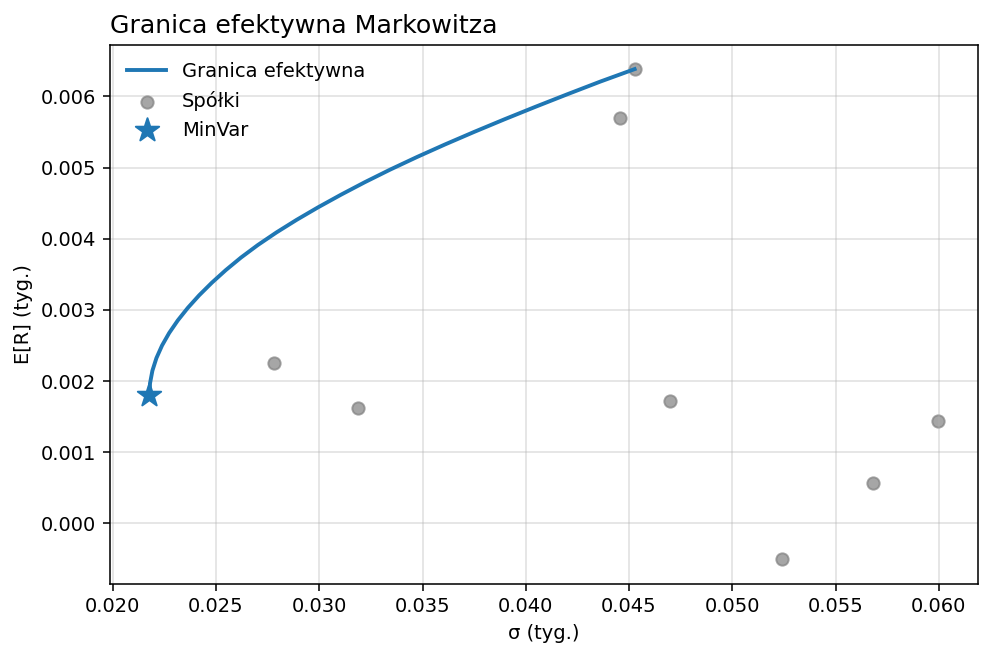

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=140)
plt.plot(ef_risks, ef_returns, lw=2, label='Granica efektywna')
plt.scatter(np.sqrt(np.diag(C)), mu, c='gray', s=40, alpha=0.7, label='Spółki')
if np.isfinite(sigma_minvar): plt.scatter(sigma_minvar, mu_minvar, marker='*', s=160, label='MinVar')
if np.isfinite(sigma_sharpe): plt.scatter(sigma_sharpe, mu_sharpe, marker='*', s=160, label='MaxSharpe')

if np.isfinite(sigma_sharpe) and sigma_sharpe>0:
    x = np.linspace(0, max(ef_risks+[sigma_sharpe])*1.05, 100)
    cml = rf_week + (mu_sharpe - rf_week)/sigma_sharpe * x
    plt.plot(x, cml, '--', alpha=0.7, label='CML')

plt.title("Granica efektywna Markowitza", loc='left', fontsize=13)
plt.xlabel("σ (tyg.)"); plt.ylabel("E[R] (tyg.)")
plt.legend(frameon=False, loc='upper left'); plt.grid(alpha=0.4)
plt.show()


In [37]:
ef_sharpes = []
for w in ef_weights:
    mu_p  = float(w @ mu.values)
    sig_p = float(np.sqrt(w @ C.values @ w))
    ef_sharpes.append( (mu_p - rf_week) / sig_p if sig_p>0 else np.nan )

i_best = int(np.nanargmax(ef_sharpes))
w_sharpe = ef_weights[i_best]
mu_sharpe = ef_returns[i_best]
sigma_sharpe = ef_risks[i_best]
sharpe_sharpe = ef_sharpes[i_best]

print("MaxSharpe z granicy: E_week=%.5f  σ_week=%.5f  Sharpe=%.3f" %
      (mu_sharpe, sigma_sharpe, sharpe_sharpe))


MaxSharpe z granicy: E_week=0.00603  σ_week=0.04202  Sharpe=0.113


In [38]:
def to_series(w):
    return pd.Series(w, index=mu.index).round(3) if w is not None else pd.Series(np.nan, index=mu.index)

weights_df = pd.DataFrame({
    "MinVar": to_series(w_minvar),
    "MaxSharpe": to_series(w_sharpe)
})
display(weights_df.T)

summary = pd.DataFrame({
    "Portfel":     ["MinVar","MaxSharpe"],
    "E_week":      [mu_minvar, mu_sharpe],
    "σ_week":      [sigma_minvar, sigma_sharpe],
    "Sharpe_week": [np.nan,     sharpe_sharpe],
    "E_annual":    [(1+mu_minvar)**52 - 1 if np.isfinite(mu_minvar) else np.nan,
                    (1+mu_sharpe)**52 - 1 if np.isfinite(mu_sharpe) else np.nan],
    "σ_annual":    [sigma_minvar*np.sqrt(52) if np.isfinite(sigma_minvar) else np.nan,
                    sigma_sharpe*np.sqrt(52) if np.isfinite(sigma_sharpe) else np.nan]
}).round(4)
display(summary)


,ACP,DNP,OPL,ATT,KGH,PGE,SPL,PKO
MinVar,0.434,0.084,0.258,0.122,0.044,0.013,0.040,0.005
MaxSharpe,0.068,0.000,0.000,0.000,0.000,0.000,0.828,0.104


,Portfel,E_week,σ_week,Sharpe_week,E_annual,σ_annual
0,MinVar,0.0018,0.0218,NaN,0.0985,0.157
1,MaxSharpe,0.0060,0.0420,0.1125,0.3670,0.303


In [41]:
w_mkt = pd.Series(np.ones(len(mu))/len(mu), index=mu.index)
mkt_tr = (train @ w_mkt).rename("MKT")

def capm_alpha_beta(asset_ret, mkt_ret, rf=0.0):
    y = asset_ret - rf
    X = sm.add_constant(mkt_ret - rf)
    model = sm.OLS(y, X).fit()
    return float(model.params["const"]), float(model.params["MKT"])

betas = {}
alphas = {}
for t in train.columns:
    a,b = capm_alpha_beta(train[t], mkt_tr, rf=rf_week)
    alphas[t]=a; betas[t]=b
betas  = pd.Series(betas)
alphas = pd.Series(alphas)

def port_metrics(w, mu, cov, mkt_ret, rf=0.0):
    w = w.loc[mu.index].values
    mu_p  = float(w @ mu.values)
    sig_p = float(np.sqrt(w @ cov.values @ w))
    sharpe = (mu_p - rf)/sig_p if sig_p>0 else np.nan
    beta_p = float((betas[mu.index] * w).sum())
    treynor = (mu_p - rf)/beta_p if beta_p!=0 else np.nan
    capm_exp = rf + beta_p*(mkt_ret.mean()-rf)
    jensen = mu_p - capm_exp
    return pd.Series({"E_week":mu_p, "σ_week":sig_p, "Sharpe":sharpe,
                      "Beta":beta_p, "Treynor":treynor, "Jensen":jensen})

qm_minvar  = port_metrics(weights_df["MinVar"],    mu, C, mkt_tr, rf_week)
qm_maxshrp = port_metrics(weights_df["MaxSharpe"], mu, C, mkt_tr, rf_week)

capm_table = pd.concat([qm_minvar, qm_maxshrp], axis=1).set_axis(["MinVar","MaxSharpe"], axis=1)
display(capm_table.round(4))

display(pd.DataFrame({"Alpha":alphas, "Beta":betas}).round(4))


,MinVar,MaxSharpe
E_week,0.0018,0.0060
σ_week,0.0218,0.0420
Sharpe,0.0232,0.1125
Beta,0.6582,1.1615
Treynor,0.0008,0.0041
Jensen,-0.0002,0.0035


,Alpha,Beta
ACP,0.0005,0.4241
DNP,-0.0005,0.8421
OPL,-0.0003,0.5763
ATT,-0.0029,1.0186
KGH,-0.0022,1.3116
PGE,-0.0014,1.3922
SPL,0.0038,1.2147
PKO,0.0031,1.2205


In [44]:
def port_series(w, rets):
    return rets @ w.loc[rets.columns].values

def var_parametric(w, mu, cov, alpha=0.95):
    wv = w.loc[mu.index].values
    mu_p  = float(wv @ mu.values)
    sigma = float(np.sqrt(wv @ cov.values @ wv))
    z = norm.ppf(1-alpha)
    VaR = -(mu_p + z*sigma)
    return VaR

def var_historic(p_series, alpha=0.95):
    q = np.quantile(p_series.values, 1-alpha)
    return -q

def vars_for(w, mu, cov, train_rets):
    p_tr = port_series(w, train_rets)
    return pd.Series({
        "VaR_param_95": var_parametric(w, mu, cov, 0.95),
        "VaR_param_99": var_parametric(w, mu, cov, 0.99),
        "VaR_hist_95":  var_historic(p_tr, 0.95),
        "VaR_hist_99":  var_historic(p_tr, 0.99),
    })

VaR_minvar  = vars_for(weights_df["MinVar"],    mu, C, train)
VaR_maxshrp = vars_for(weights_df["MaxSharpe"], mu, C, train)
display(pd.concat([VaR_minvar, VaR_maxshrp], axis=1).set_axis(["MinVar","MaxSharpe"], axis=1).round(5))

def var_hits(w, train_rets, test_rets, level=0.95, method="param"):
    if method=="param":
        thr = -var_parametric(w, mu, C, alpha=level)
    else:
        thr = np.quantile(port_series(w, train_rets).values, 1-level)
    p_test = port_series(w, test_rets)
    hits = int((p_test < thr).sum())
    return hits, len(p_test)

for name,w in [("MinVar",weights_df["MinVar"]),("MaxSharpe",weights_df["MaxSharpe"])]:
    for lvl in (0.95,0.99):
        h,N = var_hits(w, train, test, level=lvl, method="param")
        print(f"{name} — VaR{int(lvl*100)} param: przekroczeń {h}/{N}")


,MinVar,MaxSharpe
VaR_param_95,0.03401,0.06309
VaR_param_99,0.04884,0.09172
VaR_hist_95,0.03659,0.06119
VaR_hist_99,0.05296,0.09731


MinVar — VaR95 param: przekroczeń 5/52
MinVar — VaR99 param: przekroczeń 2/52
MaxSharpe — VaR95 param: przekroczeń 4/52
MaxSharpe — VaR99 param: przekroczeń 1/52


,MinVar,MaxSharpe
E_week,0.0080,0.0041
σ_week,0.0356,0.0426
Sharpe_week,0.1890,0.0648
E_annual,0.5160,0.2348
σ_annual,0.2568,0.3073


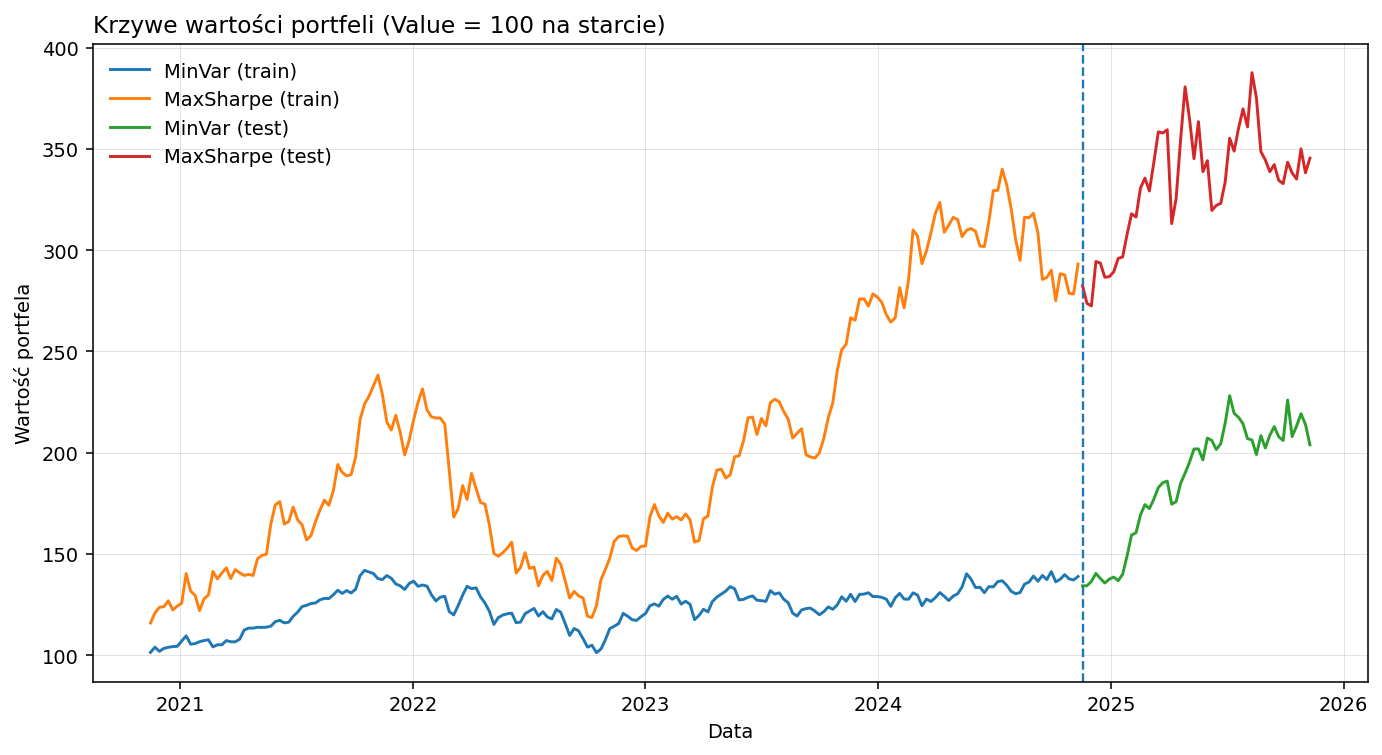

In [45]:
def oos_summary(w, test_rets, rf=0.0):
    p = port_series(w, test_rets)
    mu_w = p.mean();  sig_w = p.std(ddof=1)
    sharpe = (mu_w - rf)/sig_w if sig_w>0 else np.nan
    return pd.Series({
        "E_week":mu_w, "σ_week":sig_w, "Sharpe_week":sharpe,
        "E_annual": (1+mu_w)**52 - 1, "σ_annual": sig_w*np.sqrt(52)
    })

oos_minvar  = oos_summary(weights_df["MinVar"],    test, rf_week)
oos_maxshrp = oos_summary(weights_df["MaxSharpe"], test, rf_week)
display(pd.concat([oos_minvar, oos_maxshrp], axis=1).set_axis(["MinVar","MaxSharpe"], axis=1).round(4))

def equity_curve(w, rets, start_val=100.0):
    p = port_series(w, rets)
    return pd.Series(start_val*np.exp(np.log1p(p).cumsum()), index=rets.index)

split_date = test.index[0]
eq_minvar_tr = equity_curve(weights_df["MinVar"], train)
eq_maxsh_tr  = equity_curve(weights_df["MaxSharpe"], train)
eq_minvar_te = equity_curve(weights_df["MinVar"], test,  start_val=eq_minvar_tr.iloc[-1])
eq_maxsh_te  = equity_curve(weights_df["MaxSharpe"], test, start_val=eq_maxsh_tr.iloc[-1])

plt.figure(figsize=(10,5.5), dpi=140)
plt.plot(eq_minvar_tr.index, eq_minvar_tr, label='MinVar (train)')
plt.plot(eq_maxsh_tr.index,  eq_maxsh_tr,  label='MaxSharpe (train)')
plt.plot(eq_minvar_te.index, eq_minvar_te, label='MinVar (test)')
plt.plot(eq_maxsh_te.index,  eq_maxsh_te,  label='MaxSharpe (test)')
plt.axvline(split_date, linestyle='--', linewidth=1.2)
plt.title("Krzywe wartości portfeli (Value = 100 na starcie)", loc='left')
plt.xlabel("Data"); plt.ylabel("Wartość portfela")
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.legend(frameon=False)
plt.tight_layout(); plt.show()


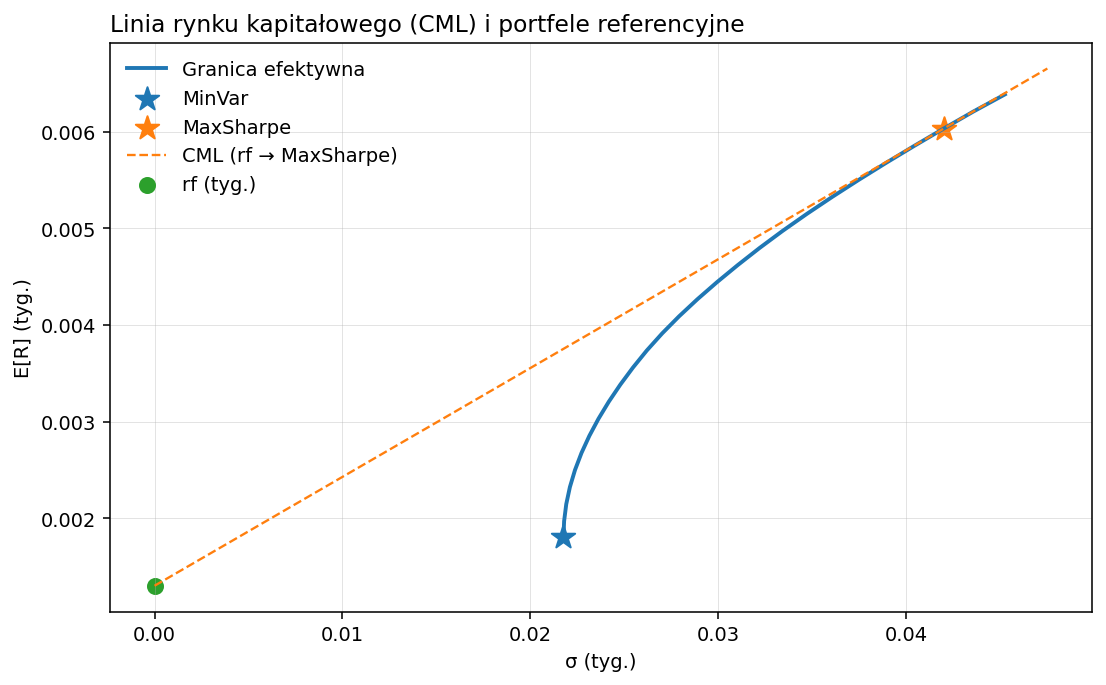

In [46]:
w_min = weights_df["MinVar"].loc[mu.index].values
mu_min  = float(w_min @ mu.values)
sig_min = float(np.sqrt(w_min @ C.values @ w_min))

plt.figure(figsize=(8,5), dpi=140)

plt.plot(ef_risks, ef_returns, lw=2, label='Granica efektywna')

plt.scatter(sig_min,     mu_min,     marker='*', s=160, label='MinVar')
plt.scatter(sigma_sharpe, mu_sharpe, marker='*', s=160, label='MaxSharpe')

x = np.linspace(0, max(ef_risks+[sigma_sharpe])*1.05, 100)
cml = rf_week + (mu_sharpe - rf_week)/sigma_sharpe * x
plt.plot(x, cml, linestyle='--', linewidth=1.2, label='CML (rf → MaxSharpe)')

plt.scatter(0, rf_week, s=60, label='rf (tyg.)')

plt.title("Linia rynku kapitałowego (CML) i portfele referencyjne", loc='left')
plt.xlabel("σ (tyg.)"); plt.ylabel("E[R] (tyg.)")
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.legend(frameon=False, loc='upper left')
plt.tight_layout(); plt.show()
